In [1]:
import sys
import os
import numpy as np
import pandas as pd
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns
import chess
import stockfish
from stockfish import Stockfish
import chess.engine
import chess.pgn
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

## Functions

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def mate_to_wp(raw_score):
    """
    Converts plys from mate to win prob 
    """
    mate_score = raw_score - np.sign(raw_score)*10000
    wp = sigmoid(3.6986223572286208 + -0.05930670977061789*np.abs(mate_score))
    if mate_score < 0:
        wp = 1-wp
    
    return wp

def cps_to_wps_evan(cps, is_white):
    """
    Converts 2d array of centipawn scores to win prob 
    """
    offset = -0.045821224987387915;
    k = 0.002226678310106879
    
    wps = np.empty(cps.shape)
    
    for i in range(cps.shape[0]):
        for j in range(cps.shape[1]):
            
            if np.abs(cps[i,j])< 10000:
                wps[i,j] = sigmoid(offset*(2*is_white-1) + k*cps[i,j])
            else:
                wps[i,j] = mate_to_wp(cps[i,j])
    return wps

def get_vocs(values_cp, wp_function, is_white, depth_0=0, depth_f=-1, fixed_sd = 0.0001, sdm = 1, upper=1,lower=0,step=0.001):
    """
    Calculates expected voc from mean and standard deviations derived from values_cp array
    """
    
    values = wp_function(values_cp, is_white)
        
    mu = values[:,depth_0]
    sigma = sdm * np.abs(values[:,depth_0]-values[:,depth_f])
    sigma = np.clip(sigma, fixed_sd, None)
    i_max = np.argmax(mu)
    
    
    x = np.arange(lower,upper,step)
    
    cdf = np.prod(stats.norm.cdf(np.tile(x,[len(mu),1]).T,loc=np.tile(mu,[len(x),1]),scale=np.tile(sigma,[len(x),1])),axis=1)
    cdf[-1]= 1
    
    max_ev = lower + np.trapz(1-cdf,dx=step)
    
    
    cdf = stats.norm.cdf(x,loc=mu[i_max],scale=sigma[i_max])
    cdf[-1]= 1
    
    base_ev = lower + np.trapz(1-cdf,dx=step)
    
    return max_ev - base_ev        
    
def get_evan(values_cp, wp_function, is_white):
    """
    Calculates the realized voc from value_cp array
    """
    values = wp_function(values_cp, is_white)
    idx = np.argmax(values[:,0])
    return np.max(values[:,-1])-values[idx,-1]



In [3]:
#Read File
#df_full = pd.read_pickle('data/processed/full_20220426.pkl')
#df_full['rt'] = df_full['rt'].shift(-1)
#df_full['voc_max'] = df_full.apply(lambda x: np.nanmax(x['voc']), axis=1)
#df_full['best_move'] = df_full.apply(lambda x: get_best_move(x['values']), axis=1)
#df_full.to_pickle('data/processed/full_20220426.pkl')
#df_full

In [4]:
#df_full = pd.read_pickle('data/processed/df_2022-05-20.pkl')

# Main Figures

In [10]:
VOC_BINS = np.linspace(-0.02,0.42,23)
VOC_BINS_c = (VOC_BINS[1:] + VOC_BINS[:-1])/2
VOC_BINS_c[0] = 0

bounds = [[15,70]]

total_games = [800012,779972,1040103,1323328, 12432, 13192]

### Plot the summaries

In [4]:
df_sum = pd.read_pickle('./data/clean/all_summary_20221003.pkl')

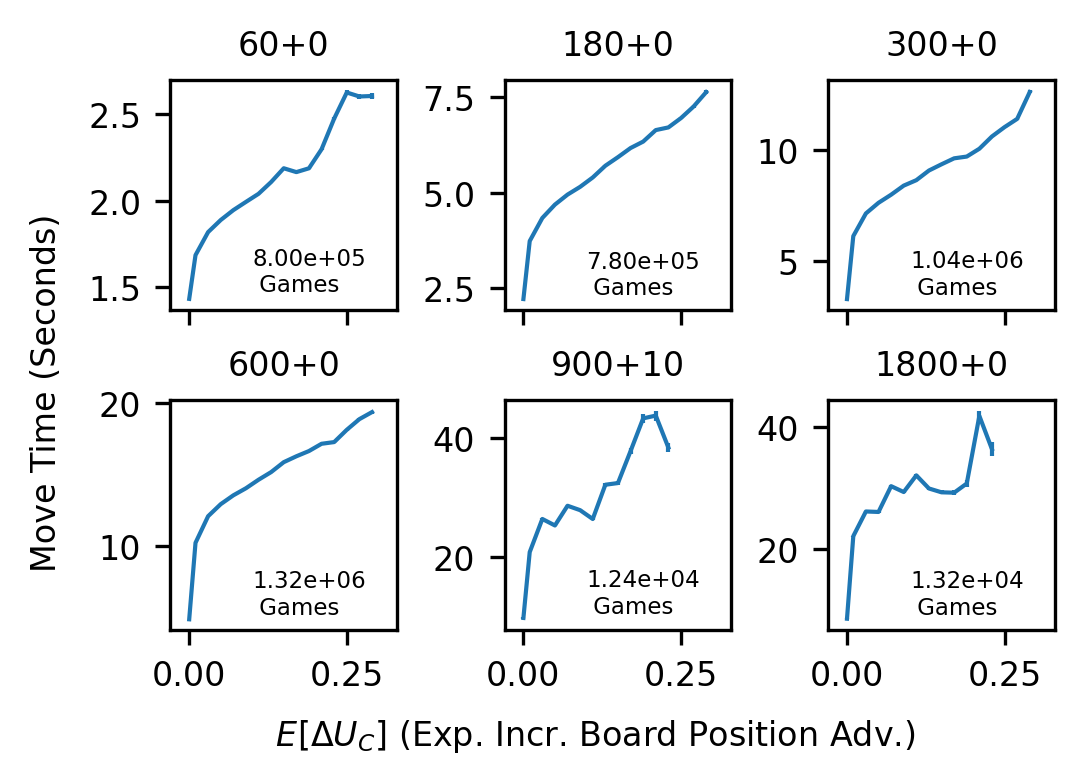

In [12]:
## Evans code

fig,ax = plt.subplots(2,3,constrained_layout=True,sharex=True,figsize=(3.5,2.5),dpi=300)
plt.rcParams['font.size'] = 8
plt.rcParams['svg.fonttype'] = 'none'

# make this a subplot
tc_df = []
time_ctrls = ['60+0','180+0','300+0','600+0', '900+10', '1800+0']

voc_type = 'voc'


for bound in bounds:
    for i in range(len(time_ctrls)):

        row = int(np.floor(i / 3))
        col = i % 3

        tc_df = df_sum[(df_sum.type == voc_type) & (df_sum.ctrl == time_ctrls[i]) & (df_sum['count'] > 1500)&
                       (df_sum.bin_c < 0.31)]

        ax[row,col].set_title(time_ctrls[i], fontsize=8)
        ax[row,col].set_xlim(xmin = -0.03, xmax = 0.33)
        ax[row,col].set_xticks([0,0.25])

        if len(tc_df) > 1:
            ax[row,col].errorbar(tc_df['bin_c'], tc_df['mean'], tc_df['std']/np.sqrt(tc_df['count']-1), linewidth=1.0, label = str(bound[0])+"-"+str(bound[1]))#rtmean,yerr=tc_df['sem'])
            
            ax[row,col].text(0.1, tc_df['mean'].min()*1.1-.1, '{:0.2e}'.format(total_games[i])+'\n Games', fontsize=5.5)
#ax[0,0].legend(prop={'size': 3})            
            
fig.supxlabel('          $E[\Delta U_C]$ (Exp. Incr. Board Position Adv.)', fontsize=8)
fig.supylabel('Move Time (Seconds)',fontsize=8)

plt.savefig("figures/3c.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("figures/3c.pdf", format='pdf', transparent=True,  bbox_inches='tight',pad_inches=0)

In [2]:
df_sum = pd.read_pickle('./data/clean/all_summary_20221003.pkl')
df_p = df_sum[(df_sum.type == 'voc_evan0')]
df_p

,voc,count,mean,std,ctrl,bin_c,type
242,"(0.0, 0.02]",20033640,10.245065,12.159540,1800+20,0.01,voc_evan0
243,"(0.02, 0.04]",12417904,12.096213,13.391927,1800+20,0.03,voc_evan0
244,"(0.04, 0.06]",7649760,12.933394,14.283713,1800+20,0.05,voc_evan0
245,"(0.06, 0.08]",4689586,13.547747,14.768108,1800+20,0.07,voc_evan0
246,"(0.08, 0.1]",3030979,14.039877,15.351566,1800+20,0.09,voc_evan0
247,"(0.1, 0.12]",1998009,14.631954,15.872199,1800+20,0.11,voc_evan0
248,"(0.12, 0.14]",1299349,15.164581,16.346031,1800+20,0.13,voc_evan0
249,"(0.14, 0.16]",820442,15.853891,16.974509,1800+20,0.15,voc_evan0
250,"(0.16, 0.18]",556841,16.262924,17.631696,1800+20,0.17,voc_evan0
251,"(0.18, 0.2]",386100,16.628002,18.072697,1800+20,0.19,voc_evan0


In [ ]:
VOC_BINS2 = np.linspace(0,0.44,23)
VOC_BINS2_c = (VOC_BINS[1:] + VOC_BINS[:-1])/2


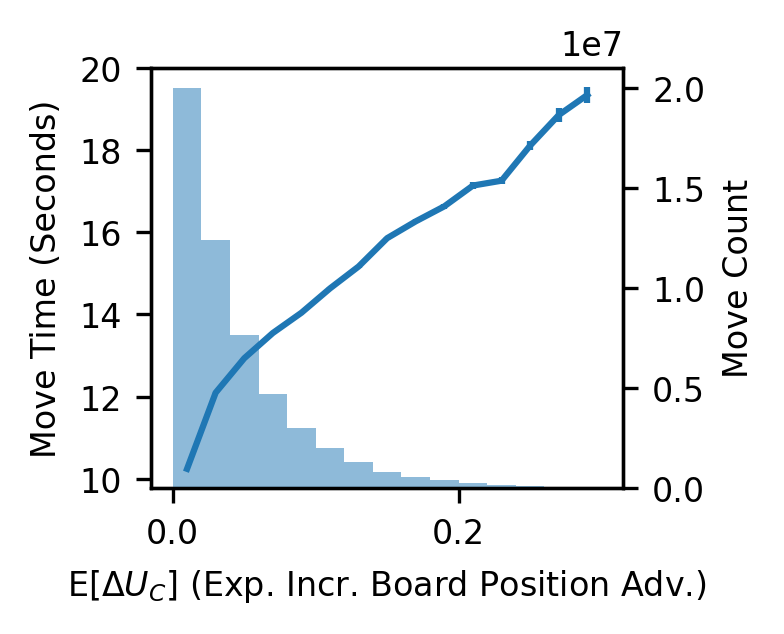

In [23]:
fig,ax = plt.subplots(1,1,constrained_layout=True,sharex=True,figsize=(2.5,2),dpi=300)
plt.rcParams['svg.fonttype'] = 'none'

df_trim = df_p[(df_p['bin_c'] < 0.3)]

ax_twin = ax.twinx()

ax_twin.bar(df_trim['bin_c'], df_trim['count'], width=0.02, alpha=0.5)

ax.errorbar(df_trim['bin_c'], df_trim['mean'], 2*df_trim['std']/np.sqrt(df_trim['count']-1))#rtmean,yerr=tc_df['sem'])

ax.set_xticks([0,0.2])

ax.set_xlabel('E[$\Delta U_C]$ (Exp. Incr. Board Position Adv.)', fontsize=8)
ax.set_ylabel('Move Time (Seconds)',fontsize=8)
ax_twin.set_ylabel('Move Count',fontsize=8)

plt.savefig("figures/3d.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("figures/3d.pdf", format='pdf', transparent=True,  bbox_inches='tight',pad_inches=0)